In [2]:
# scripts/load_data.py

import os
import psycopg2
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine


# Load environment variables from .env file
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

def load_data_from_postgres(query):
    """
    Connects to the PostgreSQL database and loads data based on the provided SQL query.

    :param query: SQL query to execute.
    :return: DataFrame containing the results of the query.
    """
    try:
        # Establish a connection to the database
        connection = psycopg2.connect(
            host=DB_HOST,
            port=DB_PORT,
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD
        )

        # Load data using pandas
        df = pd.read_sql_query(query, connection)

        # Close the database connection
        connection.close()

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None



def load_data_using_sqlalchemy(query):
    """
    Connects to the PostgreSQL database and loads data based on the provided SQL query using SQLAlchemy.

    :param query: SQL query to execute.
    :return: DataFrame containing the results of the query.
    """
    try:
        # Create a connection string
        connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

        # Create an SQLAlchemy engine
        engine = create_engine(connection_string)

        # Load data into a pandas DataFrame
        df = pd.read_sql_query(query, engine)

        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns['% of Total Values'] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns



def outliers_table(df):
    # Initialize empty lists to store results
    outliers_info = []
    
    # Iterate through numerical columns
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Z-scores
        z_scores = np.abs(zscore(df[col].dropna()))
        
        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Z-score method
        z_score_outliers = (z_scores > 3).sum()
        
        # IQR method
        iqr_outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        
        # Append results
        outliers_info.append({
            'Column': col,
            'Z-Score Outliers': z_score_outliers,
            'IQR Outliers': iqr_outliers
        })
    
    # Convert results to DataFrame
    outliers_table_df = pd.DataFrame(outliers_info)
    
    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "Outlier information for numerical columns is displayed below.")
    
    # Return the dataframe with outlier information
    return outliers_table_df


def convert_bytes_to_megabytes(df, bytes_data):
    megabyte = 1e+6  # 1 MB = 1e+6 Bytes
    df[bytes_data] = df[bytes_data] / megabyte
    return df[bytes_data]


def fix_outlier(df, column, percentile=0.95):
    threshold = df[column].quantile(percentile)
    median = df[column].median()
    df[column] = np.where(df[column] > threshold, median, df[column])
    return df[column]


def remove_outliers(df, column_to_process, z_threshold=3):
    # Apply outlier removal to the specified column
    df = df.copy()  # Avoid modifying the original DataFrame
    z_scores = zscore(df[column_to_process].dropna())
    df['z_score'] = np.nan
    df.loc[df[column_to_process].notna(), 'z_score'] = z_scores

    outlier_column = column_to_process + '_Outlier'
    df[outlier_column] = (np.abs(df['z_score']) > z_threshold).astype(int)
    df = df[df[outlier_column] == 0]  # Keep rows without outliers

    # Drop the outlier column as it's no longer needed
    df = df.drop(columns=[outlier_column, 'z_score'], errors='ignore')

    return df

In [4]:
import pandas as pd
import psycopg2

def load_data_from_postgres(query, db_params):
    """
    Load data from PostgreSQL into a Pandas DataFrame.
    
    Parameters:
    - query: SQL query to execute.
    - db_params: Dictionary containing database connection parameters.
    
    Returns:
    - DataFrame containing the query results.
    """
    try:
        # Establish the connection
        conn = psycopg2.connect(**db_params)
        
        # Load data into DataFrame
        df = pd.read_sql_query(query, conn)
        
        # Close the connection
        conn.close()
        
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Define database connection parameters
db_params = {
    'dbname': 'my_database',
    'user': 'ayalk',
    'password': '12345678',
    'host': 'localhost',
    'port': '5432'
}

# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query, db_params)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
    print(df.head())
else:
    print("Failed to load data.")


/tmp/ipykernel_29897/3617078604.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Successfully loaded the data
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          2024

In [5]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [7]:
df.shape

(150001, 55)

In [8]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


###  1. Preprocessing and Aggregating Engagement Metrics

In [9]:


# Load your DataFrame (replace with your actual data loading code)
# df = pd.read_csv('your_data_file.csv')

# Rename columns to simplify usage if needed
df.rename(columns={'MSISDN/Number': 'MSISDN', 'Dur. (ms)': 'Session Duration', 'Total DL (Bytes)': 'Download Traffic', 'Total UL (Bytes)': 'Upload Traffic'}, inplace=True)

# Fill missing values or drop rows with missing critical data if necessary
df.dropna(subset=['MSISDN', 'Session Duration', 'Download Traffic', 'Upload Traffic'], inplace=True)

# Aggregate metrics per customer
engagement_metrics = df.groupby('MSISDN').agg({
    'Session Duration': 'sum',       # Total duration in milliseconds
    'Download Traffic': 'sum',       # Total download traffic in bytes
    'Upload Traffic': 'sum',         # Total upload traffic in bytes
    'Bearer Id': 'count'             # Count sessions for frequency
}).rename(columns={'Bearer Id': 'Session Frequency'}).reset_index()

# Report the top 10 customers per metric
top_10_customers = {
    'Frequency': engagement_metrics.nlargest(10, 'Session Frequency'),
    'Duration': engagement_metrics.nlargest(10, 'Session Duration'),
    'Download Traffic': engagement_metrics.nlargest(10, 'Download Traffic'),
    'Upload Traffic': engagement_metrics.nlargest(10, 'Upload Traffic')
}

# Example of printing the top 10 customers by session frequency
print(top_10_customers['Frequency'])


             MSISDN  Session Duration  Download Traffic  Upload Traffic  \
13526  3.362632e+10         8791927.0      7.301517e+09     669650721.0   
6437   3.361489e+10         9966898.0      8.156743e+09     689483001.0   
13180  3.362578e+10        18553754.0      7.770043e+09     729577380.0   
37052  3.365973e+10         4035428.0      7.081602e+09     624260321.0   
76363  3.367588e+10         4865947.0      7.309542e+09     581568792.0   
92923  3.376054e+10         9279434.0      7.811295e+09     703478581.0   
65118  3.366716e+10         8744914.0      5.052068e+09     566326364.0   
666    3.360313e+10         6287761.0      4.540607e+09     435587631.0   
1279   3.360452e+10         5207990.0      5.096079e+09     391775856.0   
13994  3.362708e+10         4703516.0      5.309479e+09     445251947.0   

       Session Frequency  
13526                 18  
6437                  17  
13180                 17  
37052                 16  
76363                 15  
92923       

### 2. Normalize Metrics and Perform K-Means Clustering

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant columns for clustering
metrics = engagement_metrics[['Session Frequency', 'Session Duration', 'Download Traffic', 'Upload Traffic']]

# Normalize the metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(metrics)

# Apply k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=0)
engagement_metrics['Cluster'] = kmeans.fit_predict(normalized_metrics)

# Display the first few rows of the DataFrame with cluster assignments
print(engagement_metrics.head())


         MSISDN  Session Duration  Download Traffic  Upload Traffic  \
0  3.360100e+10          116720.0      8.426375e+08      36053108.0   
1  3.360100e+10          181230.0      1.207552e+08      36104459.0   
2  3.360100e+10          134969.0      5.566597e+08      39306820.0   
3  3.360101e+10           49878.0      4.019932e+08      20327526.0   
4  3.360101e+10           37104.0      1.363130e+09      94280527.0   

   Session Frequency  Cluster  
0                  1        1  
1                  1        1  
2                  1        1  
3                  1        1  
4                  2        2  


### 3. Compute and Interpret Statistics for Each Cluster

In [12]:
cluster_stats = engagement_metrics.groupby('Cluster').agg({
    'Session Frequency': ['min', 'max', 'mean', 'sum'],
    'Session Duration': ['min', 'max', 'mean', 'sum'],
    'Download Traffic': ['min', 'max', 'mean', 'sum'],
    'Upload Traffic': ['min', 'max', 'mean', 'sum']
}).reset_index()

print(cluster_stats)


  Cluster Session Frequency                      Session Duration              \
                        min max      mean    sum              min         max   
0       0                 2  18  4.401675  16295          66594.0  18553754.0   
1       1                 0   2  1.005868  79020           7142.0   1042254.0   
2       2                 1   4  2.162675  53191          18235.0   1573420.0   

                               Download Traffic                              \
            mean           sum              min           max          mean   
0  635561.260670  2.352848e+09      404647470.0  8.156743e+09  2.068793e+09   
1  103260.247623  8.112022e+09        8827082.0  1.322450e+09  4.549788e+08   
2  209553.489571  5.153968e+09       65270746.0  2.409217e+09  9.883407e+08   

                Upload Traffic                                           
            sum            min          max          mean           sum  
0  7.658671e+12     68496905.0  729577380.0  1.827

### 4. Aggregate Traffic Per Application and Find Top 10 Users

In [20]:
# Use the verified correct column name
correct_column_name = 'MSISDN/Number'  # Update this based on the actual column name

# Aggregate traffic data per user and service type
traffic_columns = [
    'Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 
    'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 
    'Other DL (Bytes)'
]

# Create a DataFrame to hold aggregated traffic per user
app_traffic = df.groupby(correct_column_name).agg({
    col: 'sum' for col in traffic_columns
}).reset_index()

# Add a 'Total Traffic' column to sum up all types of traffic
app_traffic['Total Traffic'] = app_traffic[traffic_columns].sum(axis=1)

# Find the top 10 most engaged users based on total traffic
top_users = app_traffic.nlargest(10, 'Total Traffic')

print(top_users)


KeyError: 'MSISDN/Number'

In [21]:
# Check for leading or trailing spaces in column names
df.columns = df.columns.str.strip()

# Verify the columns again
print(df.columns)


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Session Duration',
       'IMSI', 'MSISDN', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


Column names being used:
MSISDN
['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
             MSISDN  Social Media DL (Bytes)  Google DL (Bytes)  \
6437   3.361489e+10               27749744.0         93941708.0   
13526  3.362632e+10               42743837.0        116106455.0   
76363  3.367588e+10               18655364.0         83002994.0   
13180  3.362578e+10               26564121.0        107904739.0   
37052  3.365973e+10               34900444.0         90958549.0   
92923  3.376054e+10               39297646.0         88626532.0   
63028  3.366646e+10               18234924.0         62599213.0   
30715  3.365836e+10               16865613.0         58671984.0   
666    3.360313e+10               22776679.0         73942055.0   
86455  3.369879e+10               15390784.0         59943992.0   

       Email DL (Bytes)  Youtube DL (Bytes)  Netflix DL (Bytes)  \
6437     

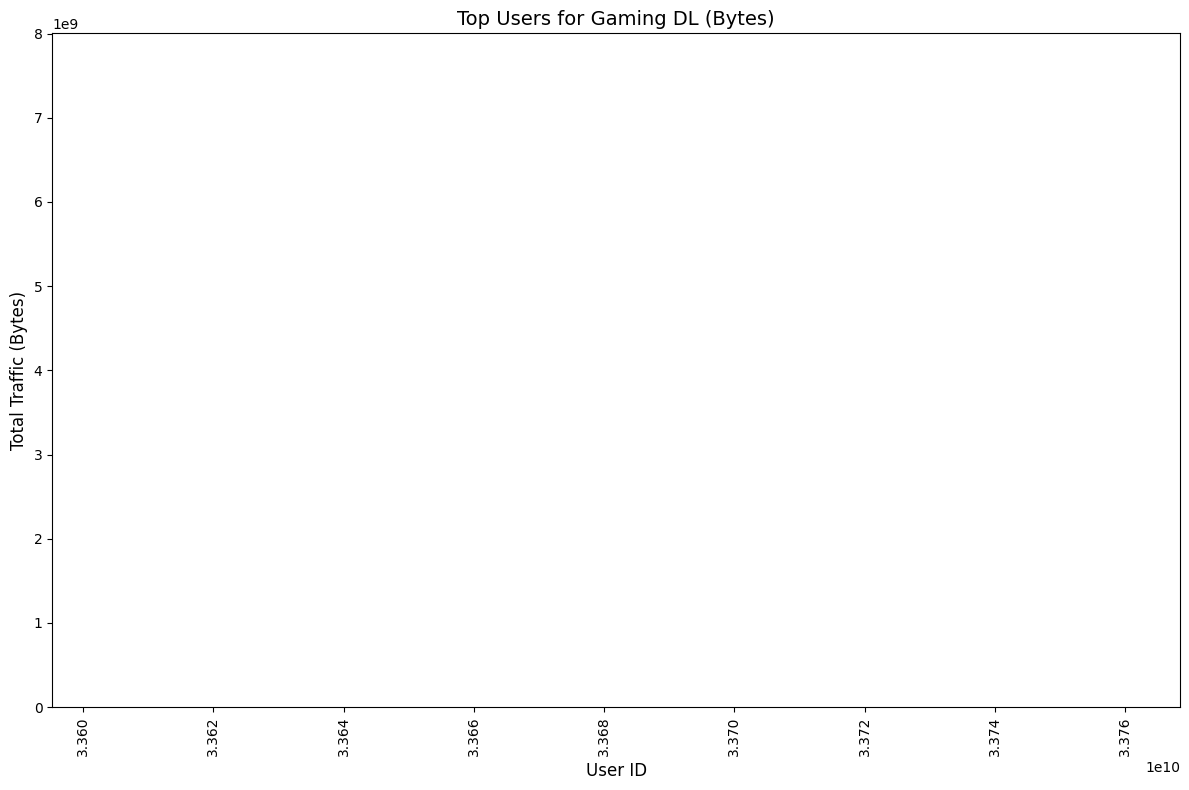

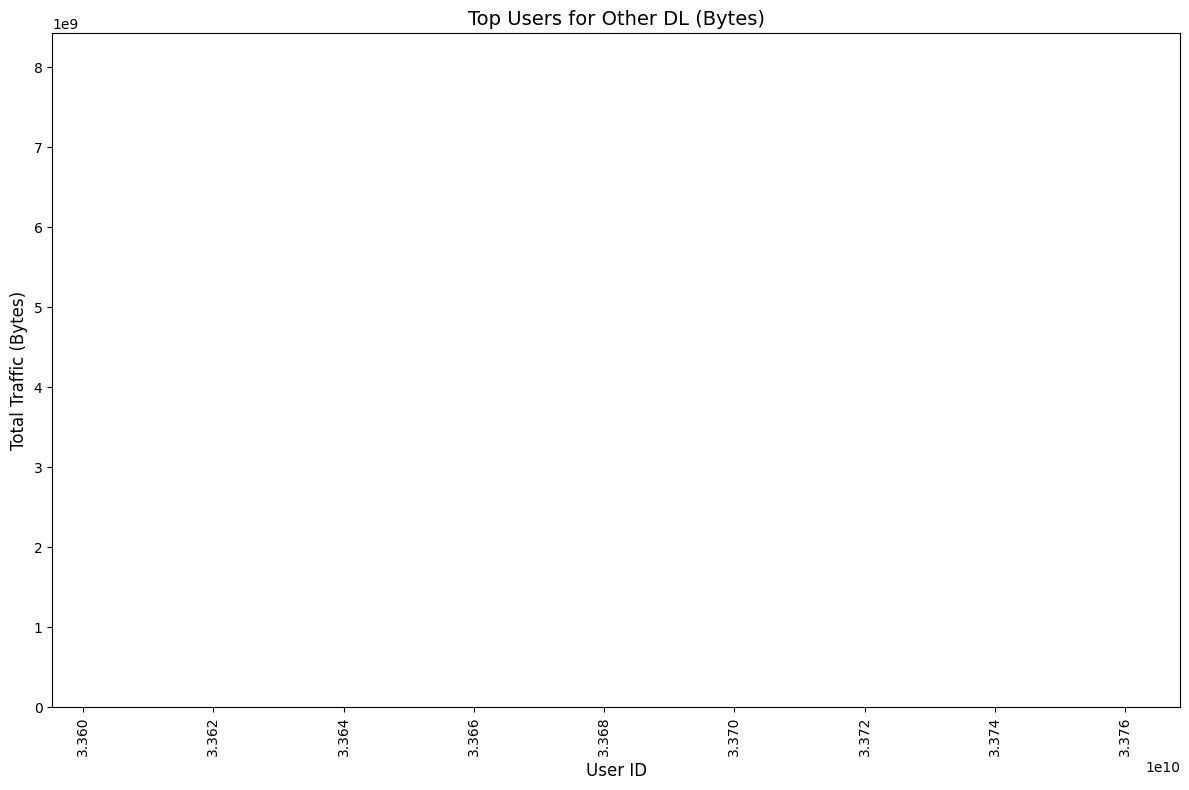

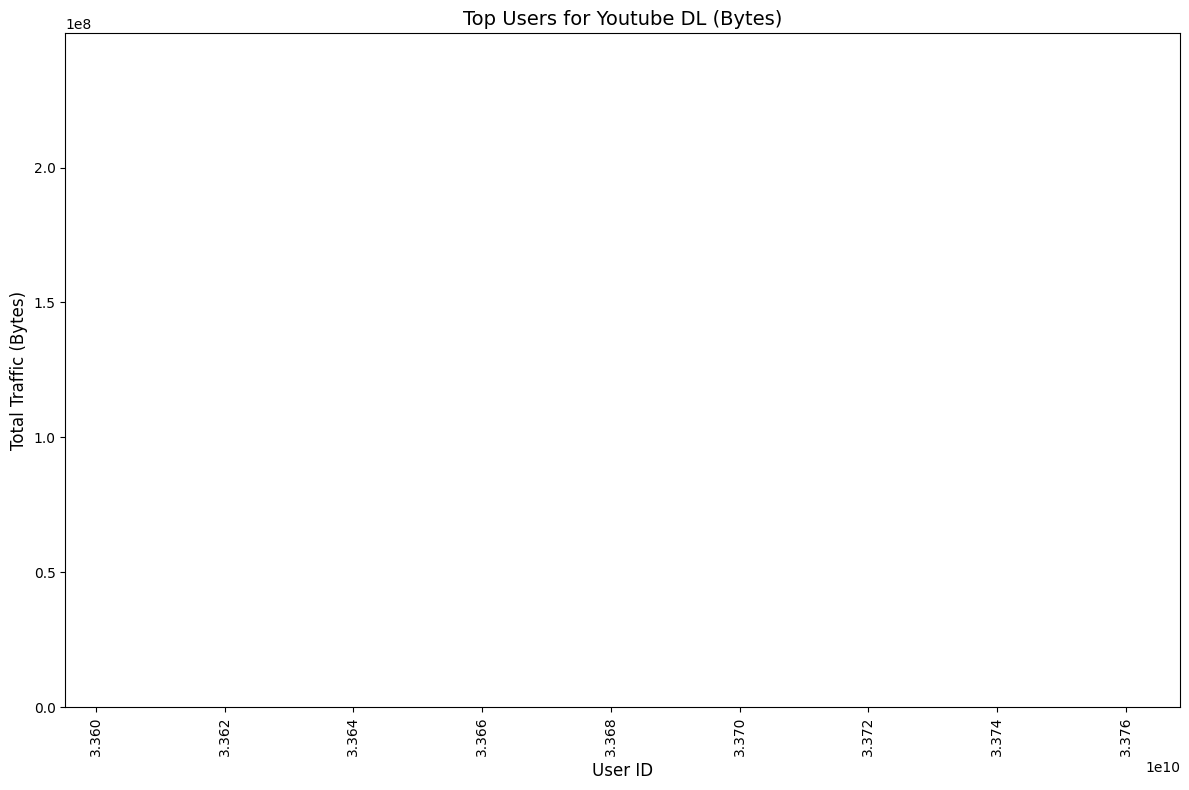

In [26]:
import matplotlib.pyplot as plt
# Use the verified correct column name
correct_column_name = 'MSISDN'  # Update based on the actual column name

# Define traffic columns
traffic_columns = [
    'Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 
    'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 
    'Other DL (Bytes)'
]

# Ensure that correct_column_name and traffic_columns are correctly specified
print("Column names being used:")
print(correct_column_name)
print(traffic_columns)

# Aggregate traffic data per user
app_traffic = df.groupby(correct_column_name).agg({
    col: 'sum' for col in traffic_columns
}).reset_index()

# Add a 'Total Traffic' column to sum up all types of traffic
app_traffic['Total Traffic'] = app_traffic[traffic_columns].sum(axis=1)

# Find the top 10 most engaged users based on total traffic
top_users = app_traffic.nlargest(10, 'Total Traffic')

print(top_users)


# Plotting
# Since we are plotting top users, we will use this data
# Define traffic columns for the plot (assuming these columns are required)
plot_traffic_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)','Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)','Other DL (Bytes)']

# Identify the top 3 most used applications from the `top_users`
top_3_apps = top_users[plot_traffic_columns].sum().nlargest(3).index

# Create a DataFrame for the top 3 apps
top_3_data = top_users[plot_traffic_columns].loc[:, top_3_apps]

# Plotting the top 3 most used applications
for app in top_3_apps:
    plt.figure(figsize=(12, 8))
    plt.bar(top_users[correct_column_name], top_users[app], color='skyblue')
    plt.xlabel('User ID', fontsize=12)
    plt.ylabel('Total Traffic (Bytes)', fontsize=12)
    plt.title(f'Top Users for {app}', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()



### 5. Plot the Top 3 Most Used Applications

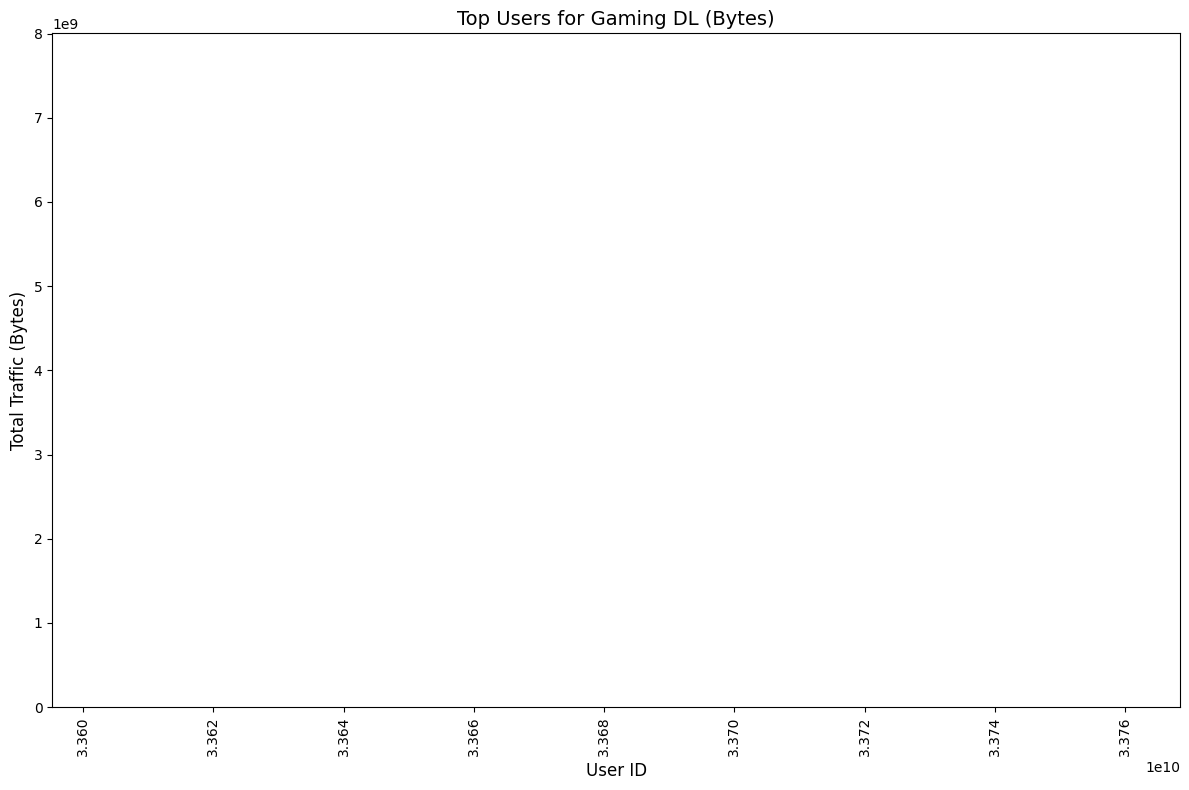

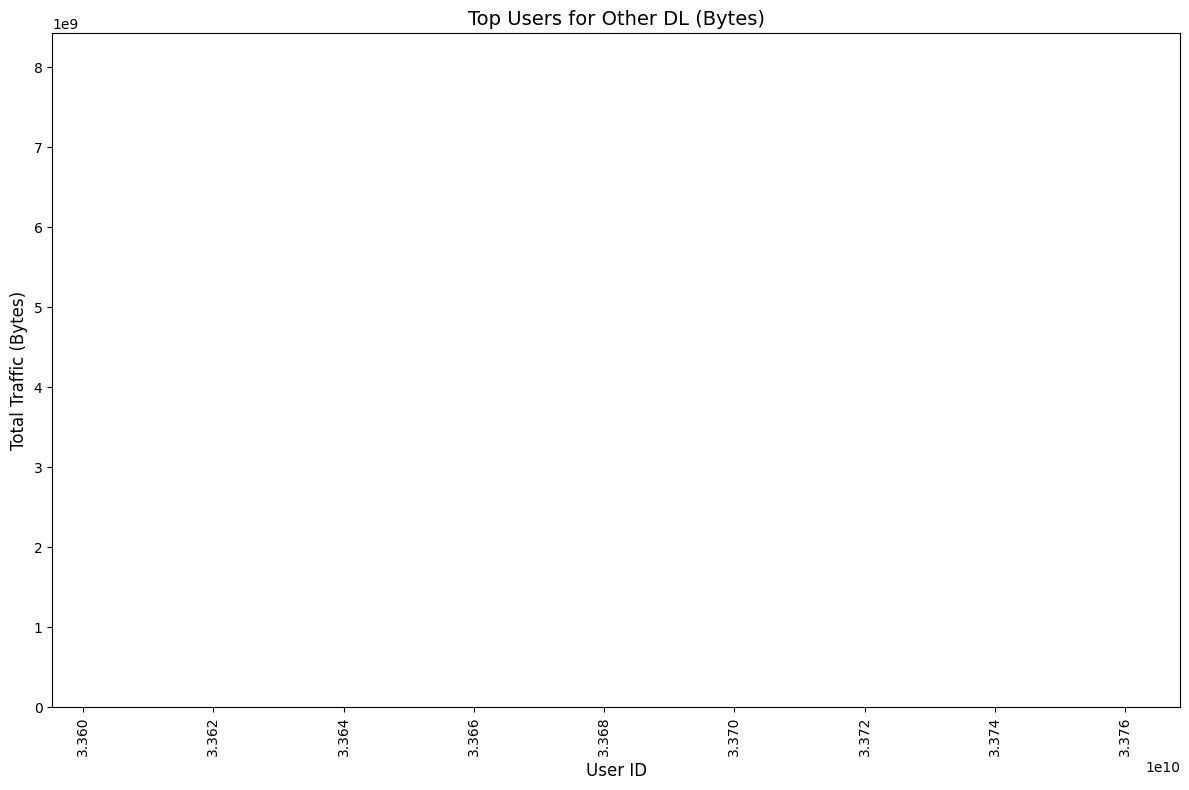

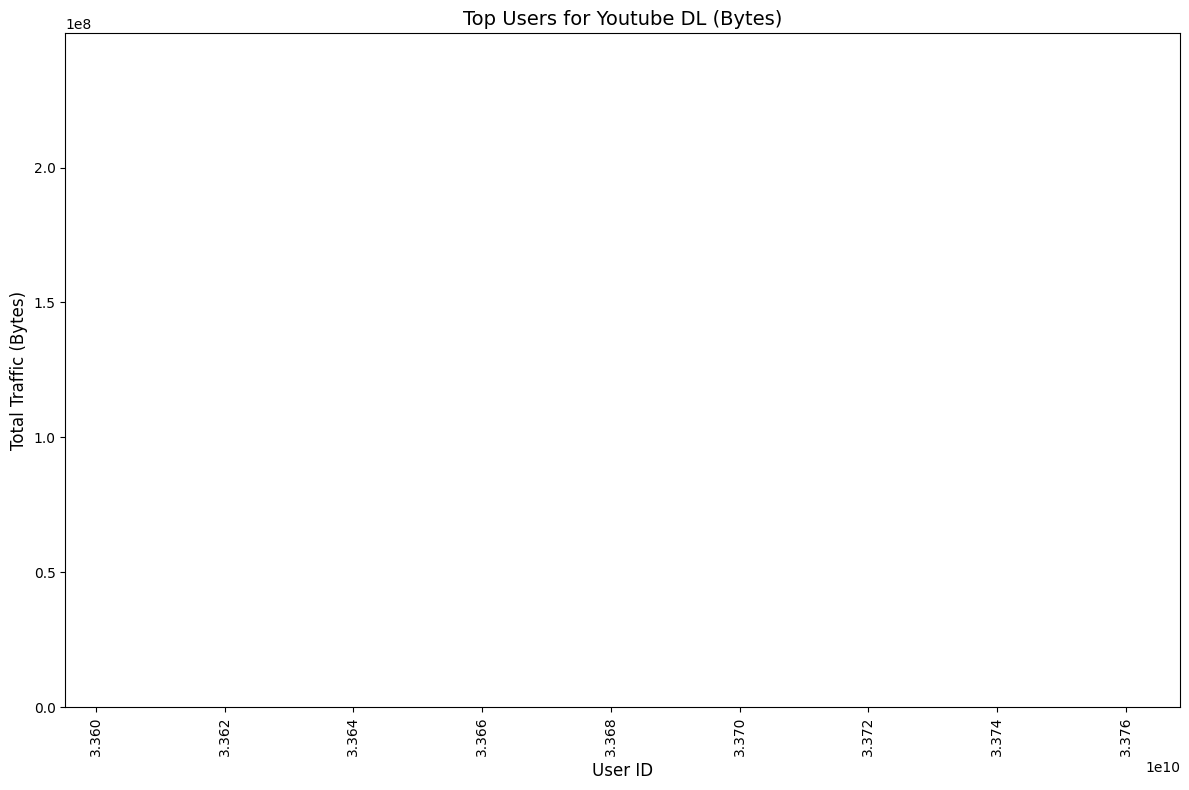

In [24]:
import matplotlib.pyplot as plt
# Plotting
# Since we are plotting top users, we will use this data
# Define traffic columns for the plot (assuming these columns are required)
plot_traffic_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)','Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)','Other DL (Bytes)']

# Identify the top 3 most used applications from the `top_users`
top_3_apps = top_users[plot_traffic_columns].sum().nlargest(3).index

# Create a DataFrame for the top 3 apps
top_3_data = top_users[plot_traffic_columns].loc[:, top_3_apps]

# Plotting the top 3 most used applications
for app in top_3_apps:
    plt.figure(figsize=(12, 8))
    plt.bar(top_users[correct_column_name], top_users[app], color='skyblue')
    plt.xlabel('User ID', fontsize=12)
    plt.ylabel('Total Traffic (Bytes)', fontsize=12)
    plt.title(f'Top Users for {app}', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()


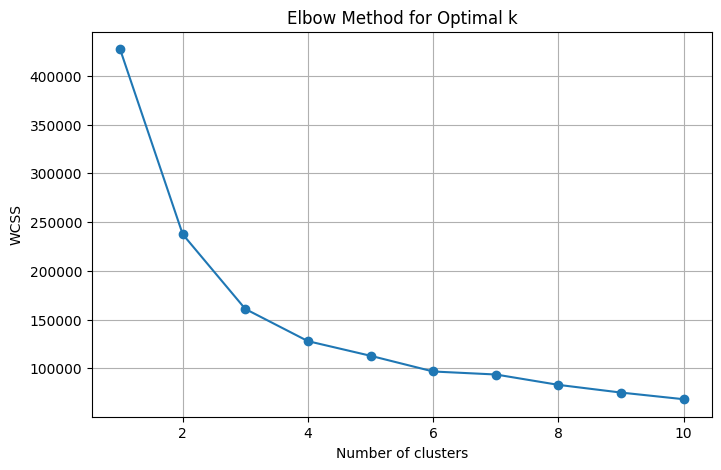

In [25]:
import matplotlib.pyplot as plt

# Compute the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(normalized_metrics)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()
